In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import json
import time
import itertools
import pickle
from scipy import stats
import psycopg2 as psql
from psycopg2.extras import RealDictCursor

import sys
sys.path.append("..")
from tools.flight_projection import *
from tools.conflict_handling import *

import seaborn as sns
sns.set(color_codes=True)

try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)
    
alt_lim = 36000
hdg_lim = 30
type_list = ['deterministic', 'probabilistic', 'intent']

/home/victor/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
def f1_score(p_dict):
    
    tp, fp, tn, fn = p_dict['TP'], p_dict['FP'], p_dict['TN'], p_dict['FN']
    
    prec = tp/(tp + fp)
    rec = tp/(tp + fn)
    
    f1 = 2*(1/(1/prec + 1/rec))
    
    return f1


def fx_score(p_dict, x):
    tp, fp, tn, fn = p_dict['TP'], p_dict['FP'], p_dict['TN'], p_dict['FN']

    if tp + fp == 0:
        return 0
        
    if tp + fn == 0:
        return 0
        
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    
    if ((x**2 * prec) + rec) == 0:
        return 0

    fx = (1 + x**2) * (prec * rec) / ((x**2 * prec) + rec)

    return fx


def calc_precision(p_dict):
    tp, fp, tn, fn = p_dict['TP'], p_dict['FP'], p_dict['TN'], p_dict['FN']
    
    if tp + fp == 0:
        return 0
        
    if tp + fn == 0:
        return 0
        
    return tp / (tp + fp)
    
    
def calc_recall(p_dict):
    tp, fp, tn, fn = p_dict['TP'], p_dict['FP'], p_dict['TN'], p_dict['FN']
    
    if tp + fp == 0:
        return 0
        
    if tp + fn == 0:
        return 0
        
    return tp / (tp + fn)


def calc_accuracy(p_dict):
    tp, fp, tn, fn = p_dict['TP'], p_dict['FP'], p_dict['TN'], p_dict['FN']
    
    if tp + fp == 0:
        return 0
        
    if tp + fn == 0:
        return 0
        
    return (tp + tn) / (tp + fp + tn + fn)
     


def load_obj(name):
    return pickle.load(open(name, "rb"))

<h2> Processing performance dictionaries </h2>

In [3]:
ti = 0

perf_dicts = {}

for ty in type_list:
    
    ttc_list = load_obj('../scripts/ttc_list_%s.pkl' % ty)
    ttc_list = [t for t in ttc_list if t[0] > 60]
    perf_dicts[ty] = create_la_performance_dict(ttc_list, bin_sec=120)

# type = type_list[ti]
# d = load_obj('../scripts/perf_dict_%s.pkl' % type)

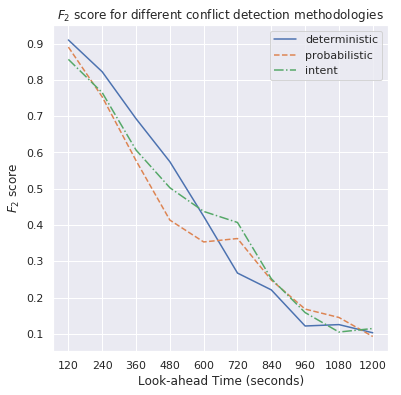

In [4]:
plt.figure(figsize=(6,6))

style_lst = iter(['-','--','-.'])

for ty in type_list:
    
    d = perf_dicts[ty]
    
    #load_obj('../scripts/perf_dict_%s.pkl' % ty)
    
    df1 = {}
    for k in d.keys():
        df1[k] = fx_score(d[k],2)
    
    la_times = [t for t in list(df1.keys())]
    ttc_list_2 = [t for t in ttc_list if t[0] > 60 and t[3] > alt_lim and t[4] > alt_lim]
    d2 = create_la_performance_dict(ttc_list_2, bin_sec=120)
    scores = [df1[k] for k in la_times]

    plt.plot(la_times, scores, linestyle=next(style_lst), label=ty)
    plt.xlabel('Look-ahead Time (seconds)')
    plt.ylabel('$F_{2}$ score')
    plt.title('$F_{2}$ score for different conflict detection methodologies')
#     plt.ylim(0,1)
    
plt.legend()
plt.show()

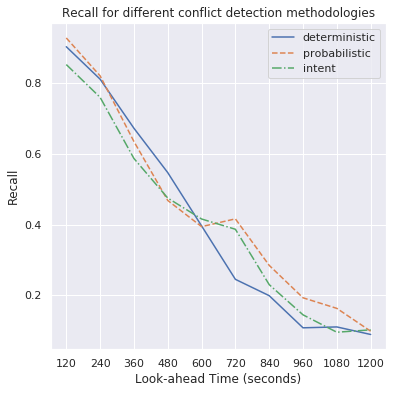

In [5]:
plt.figure(figsize=(6,6))

style_lst = iter(['-','--','-.'])

for ty in type_list:
    
    d = perf_dicts[ty]
    
    #load_obj('../scripts/perf_dict_%s.pkl' % ty)
    
    df_rec = {}
    for k in d.keys():
        df_rec[k] = calc_recall(d[k])
    
    la_times = [t for t in list(df_rec.keys())]
    ttc_list_2 = [t for t in ttc_list if t[0] > 60 and t[3] > alt_lim and t[4] > alt_lim]
#     d2 = create_la_performance_dict(ttc_list_2, bin_sec=120)
    recall = [df_rec[k] for k in la_times]

    plt.plot(la_times, recall, linestyle=next(style_lst), label=ty)
    plt.xlabel('Look-ahead Time (seconds)')
    plt.ylabel('Recall')
    plt.title('Recall for different conflict detection methodologies')
#     plt.ylim(0,1)

plt.legend()
plt.show()

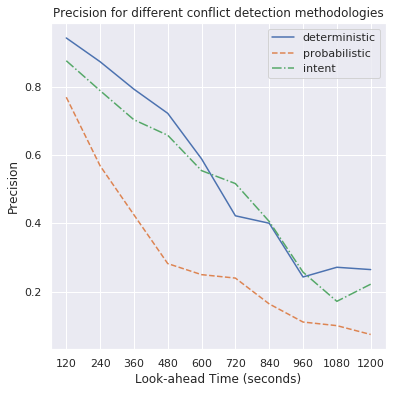

In [6]:
plt.figure(figsize=(6,6))

style_lst = iter(['-','--','-.'])

for ty in type_list:
    
    d = perf_dicts[ty]
    
    #load_obj('../scripts/perf_dict_%s.pkl' % ty)
    
    df_prec = {}
    for k in d.keys():
        df_prec[k] = calc_precision(d[k])
    
    la_times = [t for t in list(df_prec.keys())]
    ttc_list_2 = [t for t in ttc_list if t[0] > 60 and t[3] > alt_lim and t[4] > alt_lim]
#     d2 = create_la_performance_dict(ttc_list_2, bin_sec=120)
    precision = [df_prec[k] for k in la_times]
    
    plt.plot(la_times, precision, linestyle=next(style_lst), label=ty)
    plt.xlabel('Look-ahead Time (seconds)')
    plt.ylabel('Precision')
    plt.title('Precision for different conflict detection methodologies')
#     plt.ylim(0,1)
    
plt.legend()
plt.show()

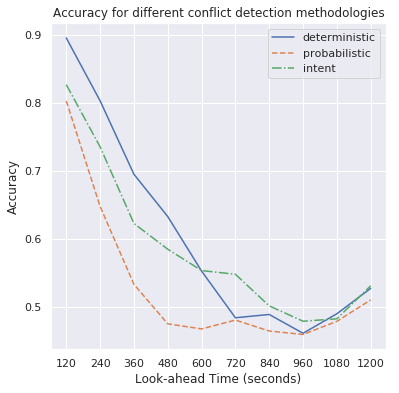

In [7]:
plt.figure(figsize=(6,6))

style_lst = iter(['-','--','-.'])

for ty in type_list:
    
    d = perf_dicts[ty]
    
    #load_obj('../scripts/perf_dict_%s.pkl' % ty)
    
    df_acc = {}
    for k in d.keys():
        df_acc[k] = calc_accuracy(d[k])
    
    la_times = [t for t in list(df_acc.keys())]
    ttc_list_2 = [t for t in ttc_list if t[0] > 60 and t[3] > alt_lim and t[4] > alt_lim]
#     d2 = create_la_performance_dict(ttc_list_2, bin_sec=120)
    acc = [df_acc[k] for k in la_times]
    
    plt.plot(la_times, acc, linestyle=next(style_lst), label=ty)
    plt.xlabel('Look-ahead Time (seconds)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for different conflict detection methodologies')
#     plt.ylim(0,1)
    
plt.legend()
plt.show()

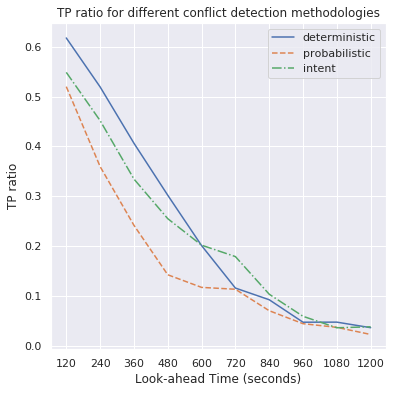

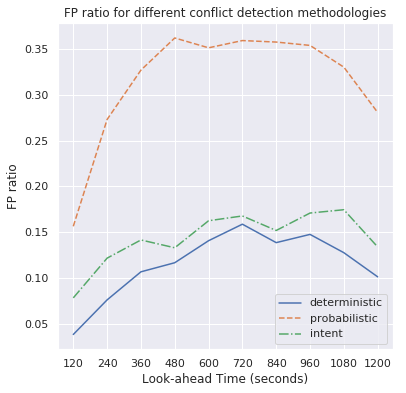

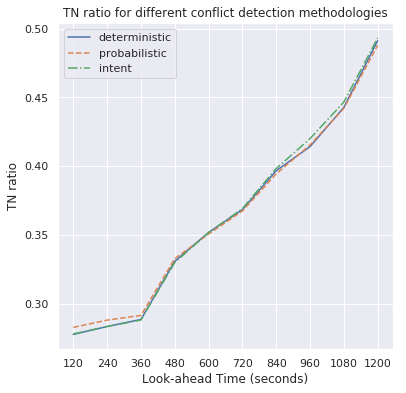

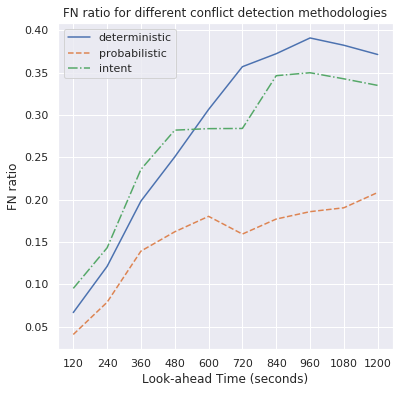

In [8]:
for ft in ['TP', 'FP', 'TN', 'FN']:
    style_lst = iter(['-','--','-.'])
    plt.figure(figsize=(6,6))
    for ty in type_list:
        
        d = perf_dicts[ty]

        la_times = [t for t in list(df1.keys())]
#         scores = [d[k][ft] for k in la_times]
        cnt = sum([d[k][ft] for k in df1.keys()])
        scores = [d[k][ft]/sum([d[k][ft] for ft in ['TP', 'FP', 'TN', 'FN']]) for k in la_times]
#         scores = [d[k][ft] for k in df1.keys()]
        
        plt.plot(la_times, scores, linestyle=next(style_lst), label=ty)
        plt.xlabel('Look-ahead Time (seconds)')
        plt.ylabel('{} ratio'.format(ft))
        plt.title('{} ratio for different conflict detection methodologies'.format(ft))
        plt.legend()
    plt.show()

## Segmentation on flight level

In [6]:
plt.figure(figsize=(6,6))

style_lst = iter(['-','--','-.'])
for ty in type_list:
    
    l_style = next(style_lst)
    
    ttc_list_1 = load_obj('../scripts/ttc_list_%s.pkl' % ty)
    ttc_list_1 = [t for t in ttc_list_1 if t[0] > 60 and t[3] < alt_lim and t[4] < alt_lim]
    d1 = create_la_performance_dict(ttc_list_1, bin_sec=120)

    df1 = {}
    df1_acc = {}
    for k in d1.keys():
        df1[k] = fx_score(d1[k],2)
#         df1_acc[k] = calc_accuracy(d1[k])

    la_times_1 = [t for t in list(df1.keys())]
#     acc1 = [df1_acc[k] for k in la_times_1]
    scores_1 = [df1[k] for k in la_times_1]

    ttc_list_2 = load_obj('../scripts/ttc_list_%s.pkl' % ty)
    ttc_list_2 = [t for t in ttc_list_2 if t[0] > 60 and t[3] > alt_lim and t[4] > alt_lim]
    d2 = create_la_performance_dict(ttc_list_2, bin_sec=120)

    df2 = {}
    df2_acc = {}
    for k in d2.keys():
        df2[k] = fx_score(d2[k],2)
#         df2_acc[k] = calc_accuracy(d2[k])

    la_times_2 = [t for t in list(df2.keys())]
#     acc2 = [df2_acc[k] for k in la_times_2]
    scores_2 = [df2[k] for k in la_times_2]

    plt.plot(la_times_1, scores_1, linestyle='-', label='{0} < FL{1}'.format(ty,int(alt_lim/100)))
    plt.plot(la_times_2, scores_2, linestyle='-.', label='{0} > FL{1}'.format(ty,int(alt_lim/100)))
    plt.xlabel('Look-ahead Time (seconds)')
    plt.ylabel('$F_{2}$ score')
    plt.title('$F_{2}$ score for different conflict detection methodologies \n separating by heading difference')
    
plt.legend()
plt.show()

AttributeError: 'Figure' object has no attribute 'plot'

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

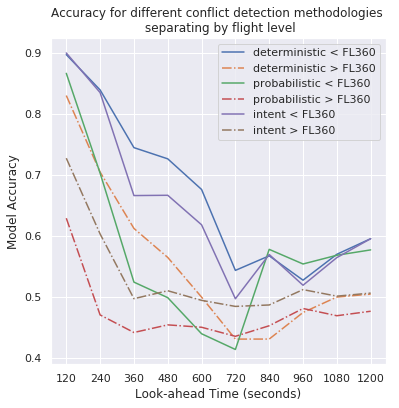

In [8]:
plt.figure(figsize=(6,6))

style_lst = iter(['-','--','-.'])
for ty in type_list:
    
    l_style = next(style_lst)
    
    ttc_list_1 = load_obj('../scripts/ttc_list_%s.pkl' % ty)
    ttc_list_1 = [t for t in ttc_list_1 if t[0] > 60 and t[3] < alt_lim and t[4] < alt_lim]
    d1 = create_la_performance_dict(ttc_list_1, bin_sec=120)

    df1 = {}
    df1_acc = {}
    for k in d1.keys():
        df1[k] = fx_score(d1[k],2)
        df1_acc[k] = calc_accuracy(d1[k])

    la_times_1 = [t for t in list(df1.keys())]
    acc1 = [df1_acc[k] for k in la_times_1]
    scores_1 = [df1[k] for k in la_times_1]

    ttc_list_2 = load_obj('../scripts/ttc_list_%s.pkl' % ty)
    ttc_list_2 = [t for t in ttc_list_2 if t[0] > 60 and t[3] > alt_lim and t[4] > alt_lim]
    d2 = create_la_performance_dict(ttc_list_2, bin_sec=120)

    df2 = {}
    df2_acc = {}
    for k in d2.keys():
        df2[k] = fx_score(d2[k],2)
        df2_acc[k] = calc_accuracy(d2[k])

    la_times_2 = [t for t in list(df2.keys())]
    acc2 = [df2_acc[k] for k in la_times_2]
    scores_2 = [df2[k] for k in la_times_2]
    
    plt.plot(la_times_1, acc1, linestyle='-', label='{0} < FL{1}'.format(ty,int(alt_lim/100)))
    plt.plot(la_times_2, acc2, linestyle='-.', label='{0} > FL{1}'.format(ty,int(alt_lim/100)))
    plt.xlabel('Look-ahead Time (seconds)')
    plt.ylabel('Model Accuracy')
    plt.title('Accuracy for different conflict detection methodologies \n separating by flight level')
    
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(6,6))

style_lst = iter(['-','--','-.'])

for ty in type_list:
    
    d = perf_dicts[ty]
    
    #load_obj('../scripts/perf_dict_%s.pkl' % ty)
    
    df_acc = {}
    for k in d.keys():
        df_acc[k] = calc_accuracy(d[k])
    
    la_times = [t for t in list(df_acc.keys())]
    ttc_list_2 = [t for t in ttc_list if t[0] > 60 and t[3] > alt_lim and t[4] > alt_lim]
#     d2 = create_la_performance_dict(ttc_list_2, bin_sec=120)
    acc = [df_acc[k] for k in la_times]
    
    plt.plot(la_times, acc, linestyle=next(style_lst), label=ty)
    plt.xlabel('Look-ahead Time (seconds)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for different conflict detection methodologies')
#     plt.ylim(0,1)
    
plt.legend()
plt.show()

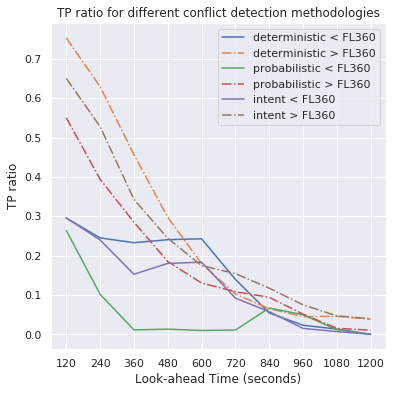

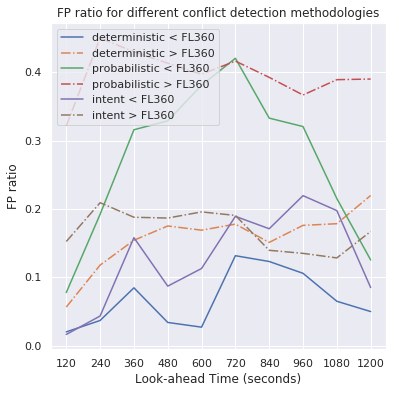

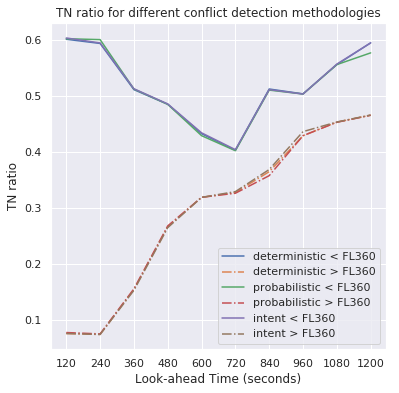

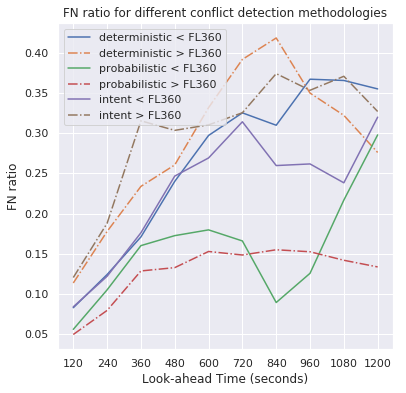

In [15]:
for ft in ['TP', 'FP', 'TN', 'FN']:

    plt.figure(figsize=(6,6))
    style_lst = iter(['-','--','-.'])
    for ty in type_list:

        l_style = next(style_lst)

        ttc_list_1 = load_obj('../scripts/ttc_list_%s.pkl' % ty)
        ttc_list_1 = [t for t in ttc_list_1 if t[0] > 60 and t[3] < alt_lim and t[4] < alt_lim]
        d1 = create_la_performance_dict(ttc_list_1, bin_sec=120)

        la_times_1 = [t for t in list(df1.keys())]
        scores_1 = [d1[k][ft]/sum([d1[k][ft] for ft in ['TP', 'FP', 'TN', 'FN']]) for k in la_times_1]

        ttc_list_2 = load_obj('../scripts/ttc_list_%s.pkl' % ty)
        ttc_list_2 = [t for t in ttc_list_2 if t[0] > 60 and t[3] > alt_lim and t[4] > alt_lim]
        d2 = create_la_performance_dict(ttc_list_2, bin_sec=120)

        la_times_2 = [t for t in list(df2.keys())]
        scores_2 = [d2[k][ft]/sum([d2[k][ft] for ft in ['TP', 'FP', 'TN', 'FN']]) for k in la_times_2]

        plt.plot(la_times_1, scores_1, linestyle='-', label='{0} < FL{1}'.format(ty,int(alt_lim/100)))
        plt.plot(la_times_2, scores_2, linestyle='-.', label='{0} > FL{1}'.format(ty,int(alt_lim/100)))
        plt.xlabel('Look-ahead Time (seconds)')
        plt.ylabel('{} ratio'.format(ft))
        plt.title('{} ratio for different conflict detection methodologies'.format(ft))
    #     plt.ylim(0,1)

    plt.legend()
    plt.show()

## Segmentation on heading difference

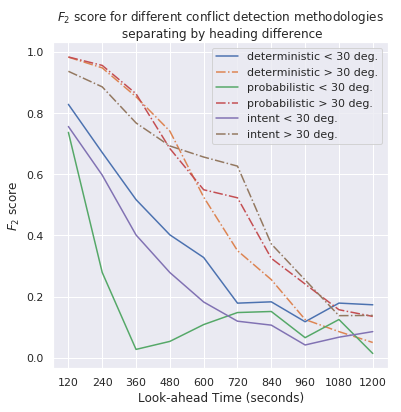

In [11]:


plt.figure(figsize=(6,6))
style_lst = iter(['-','--','-.'])
for ty in type_list:
    
    l_style = next(style_lst)
    
    ttc_list_1 = load_obj('../scripts/ttc_list_%s.pkl' % ty)
    ttc_list_1 = [t for t in ttc_list_1 if t[0] > 60 and abs(t[7]) < hdg_lim]
    d1 = create_la_performance_dict(ttc_list_1, bin_sec=120)

    df1 = {}
    for k in d1.keys():
        df1[k] = fx_score(d1[k],2)

    la_times_1 = [t for t in list(df1.keys())]
    scores_1 = [df1[k] for k in la_times_1]

    ttc_list_2 = load_obj('../scripts/ttc_list_%s.pkl' % ty)
    ttc_list_2 = [t for t in ttc_list_2 if t[0] > 60 and abs(t[7]) > hdg_lim]
    d2 = create_la_performance_dict(ttc_list_2, bin_sec=120)

    df2 = {}
    for k in d2.keys():
        df2[k] = fx_score(d2[k],2)

    la_times_2 = [t for t in list(df2.keys())]
    scores_2 = [df2[k] for k in la_times_2]

    plt.plot(la_times_1, scores_1, linestyle='-', label='{0} < {1} deg.'.format(ty,hdg_lim))
    plt.plot(la_times_2, scores_2, linestyle='-.', label='{0} > {1} deg.'.format(ty,hdg_lim))
    plt.xlabel('Look-ahead Time (seconds)')
    plt.ylabel('$F_{2}$ score')
    plt.title('$F_{2}$ score for different conflict detection methodologies \n separating by heading difference')
#     plt.ylim(0,1)
    
plt.legend()
plt.show()

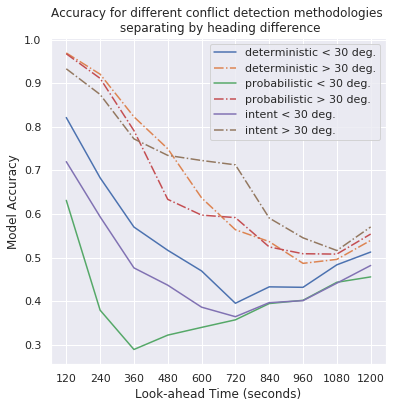

In [11]:
plt.figure(figsize=(6,6))

style_lst = iter(['-','--','-.'])
for ty in type_list:
    
    l_style = next(style_lst)
    
    ttc_list_1 = load_obj('../scripts/ttc_list_%s.pkl' % ty)
    ttc_list_1 = [t for t in ttc_list_1 if t[0] > 60 and abs(t[7]) <= hdg_lim]
    d1 = create_la_performance_dict(ttc_list_1, bin_sec=120)

    df1 = {}
    df1_acc = {}
    for k in d1.keys():
        df1[k] = fx_score(d1[k],2)
        df1_acc[k] = calc_accuracy(d1[k])

    la_times_1 = [t for t in list(df1.keys())]
    acc1 = [df1_acc[k] for k in la_times_1]
    scores_1 = [df1[k] for k in la_times_1]

    ttc_list_2 = load_obj('../scripts/ttc_list_%s.pkl' % ty)
    ttc_list_2 = [t for t in ttc_list_2 if t[0] > 60 and abs(t[7]) > hdg_lim]
    d2 = create_la_performance_dict(ttc_list_2, bin_sec=120)

    df2 = {}
    df2_acc = {}
    for k in d2.keys():
        df2[k] = fx_score(d2[k],2)
        df2_acc[k] = calc_accuracy(d2[k])

    la_times_2 = [t for t in list(df2.keys())]
    acc2 = [df2_acc[k] for k in la_times_2]
    scores_2 = [df2[k] for k in la_times_2]
    
    plt.plot(la_times_1, acc1, linestyle='-', label='{0} < {1} deg.'.format(ty,hdg_lim))
    plt.plot(la_times_2, acc2, linestyle='-.', label='{0} > {1} deg.'.format(ty,hdg_lim))
    plt.xlabel('Look-ahead Time (seconds)')
    plt.ylabel('Model Accuracy')
    plt.title('Accuracy for different conflict detection methodologies \n separating by heading difference')
    
plt.legend()
plt.show()

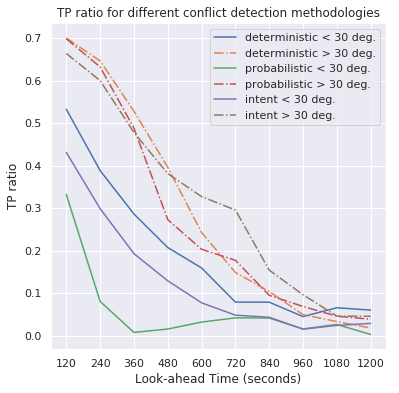

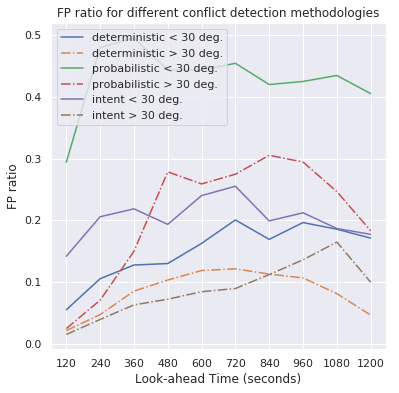

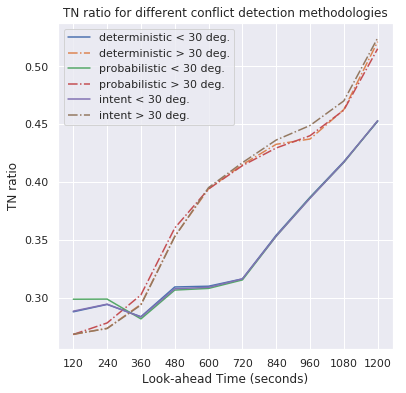

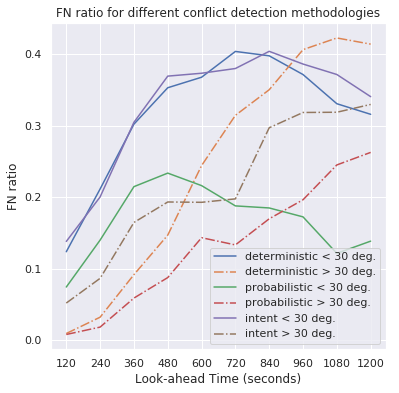

In [12]:
for ft in ['TP', 'FP', 'TN', 'FN']:

    plt.figure(figsize=(6,6))
    style_lst = iter(['-','--','-.'])
    for ty in type_list:

        l_style = next(style_lst)

        ttc_list_1 = load_obj('../scripts/ttc_list_%s.pkl' % ty)
        ttc_list_1 = [t for t in ttc_list_1 if t[0] > 60 and abs(t[7]) < hdg_lim]
        d1 = create_la_performance_dict(ttc_list_1, bin_sec=120)

        la_times_1 = [t for t in list(df1.keys())]
        scores_1 = [d1[k][ft]/sum([d1[k][ft] for ft in ['TP', 'FP', 'TN', 'FN']]) for k in la_times_1]

        ttc_list_2 = load_obj('../scripts/ttc_list_%s.pkl' % ty)
        ttc_list_2 = [t for t in ttc_list_2 if t[0] > 60 and abs(t[7]) > hdg_lim]
        d2 = create_la_performance_dict(ttc_list_2, bin_sec=120)

        la_times_2 = [t for t in list(df2.keys())]
        scores_2 = [d2[k][ft]/sum([d2[k][ft] for ft in ['TP', 'FP', 'TN', 'FN']]) for k in la_times_2]

        plt.plot(la_times_1, scores_1, linestyle='-', label='{0} < {1} deg.'.format(ty,hdg_lim))
        plt.plot(la_times_2, scores_2, linestyle='-.', label='{0} > {1} deg.'.format(ty,hdg_lim))
        plt.xlabel('Look-ahead Time (seconds)')
        plt.ylabel('{} ratio'.format(ft))
        plt.title('{} ratio for different conflict detection methodologies'.format(ft))
    #     plt.ylim(0,1)

    plt.legend()
    plt.show()

## Analyze TTC results

188205


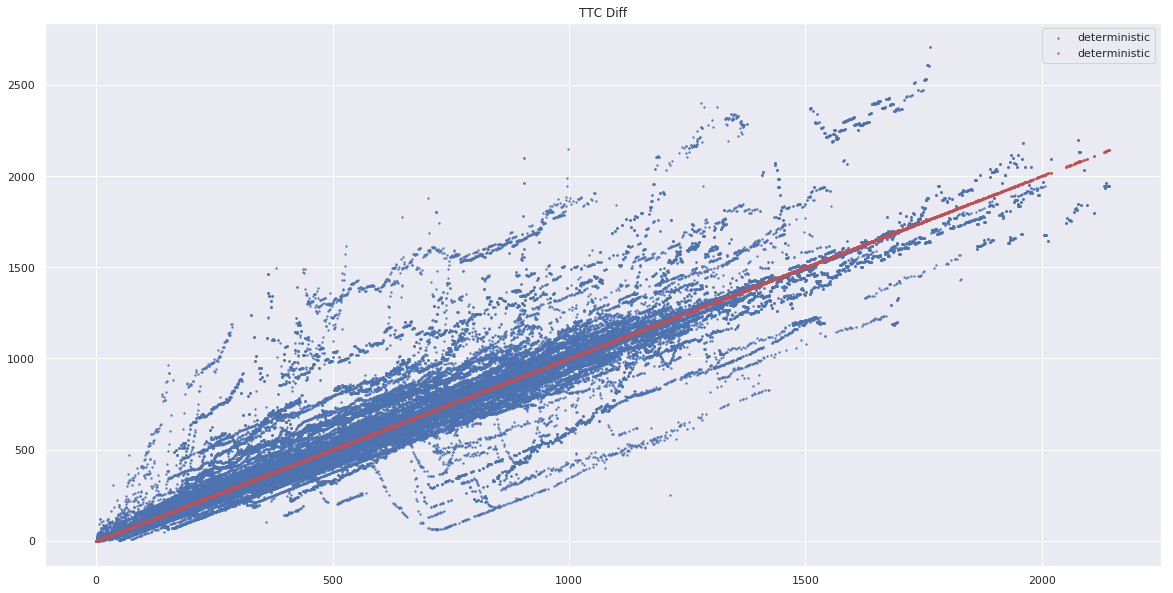

235145


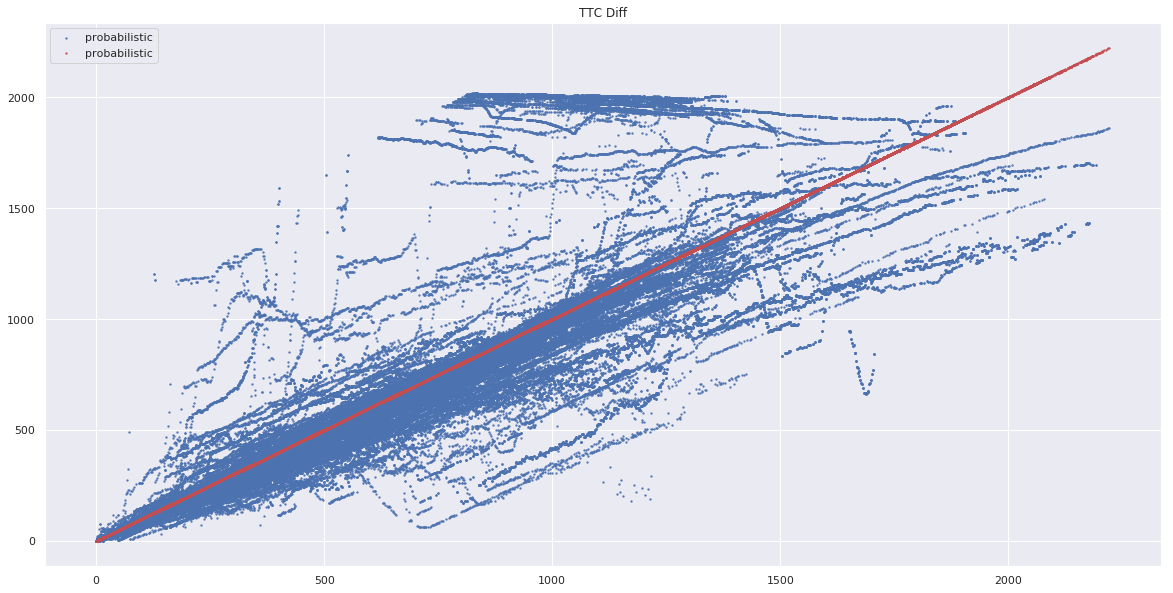

194656


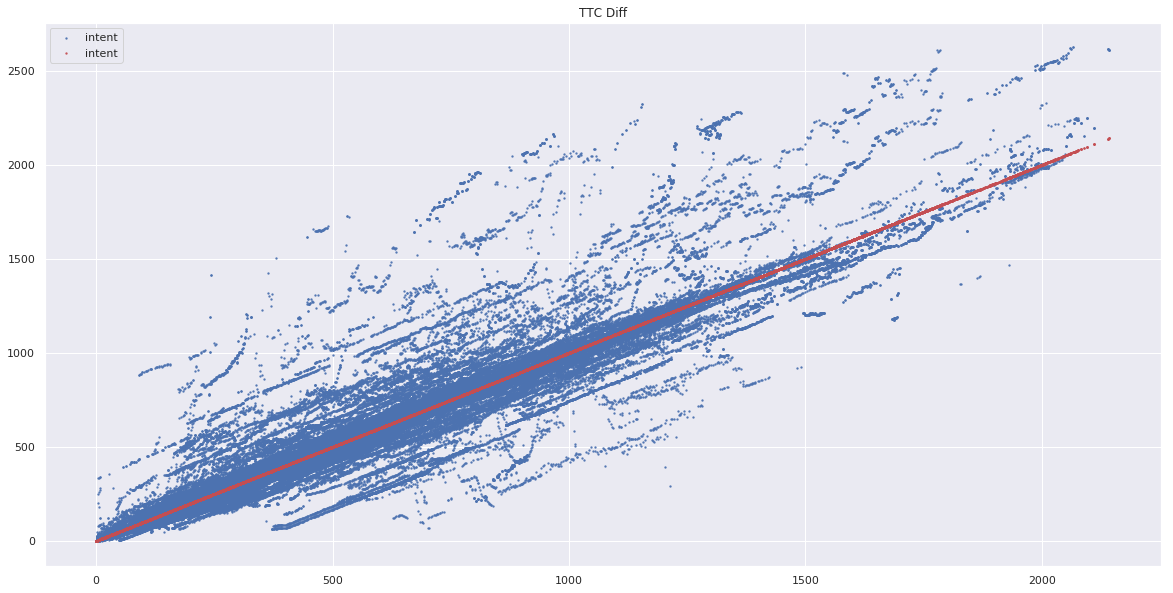

In [4]:
for ty in type_list:
    plt.figure(figsize=(20,10))
    d = load_obj('../scripts/ttc_list_%s.pkl' % ty)
    ttc_act = []
    ttc_est = []
    ttc_diff = []
    la_t = []

    for v in d:
        if ~np.isnan(v[1]) and ~np.isnan(v[2]):
            ttc_act.append(v[1])
            ttc_est.append(v[2])
            ttc_diff.append(v[2] - v[1])
            la_t.append(v[0])


    plt.title('TTC Diff')
#     plt.xlim(0,1200)
#     plt.ylim(-20,100)
    plt.scatter(la_t, ttc_est, label=ty, s=2, alpha=0.8)
    plt.scatter(la_t, ttc_act, label=ty, s=2, alpha=0.8, color='r')
    print(len(ttc_est))
#     plt.ylim(-100,100)
    plt.legend()
    plt.show()

In [ ]:
ty = 'intent'
d = load_obj('../scripts/ttc_list_%s.pkl' % ty)
fn_1 = len([v for v in d if ~np.isnan(v[2]) and ~np.isnan(v[1]) and v[1] <= la_time and ((v[2] - v[1]) > v[1]*0.1)])
fn_2 = len([v for v in d if np.isnan(v[2]) and ~np.isnan(v[1]) and v[1] <= la_time])
tp_1 = len([v for v in d if ~np.isnan(v[2]) and ~np.isnan(v[1]) and v[1] <= la_time and (-120 < (v[2] - v[1]) < v[1]*0.1)])

print(fn_1/fn_2)
print(fn_1 + fn_2)

In [ ]:
n, bins, patches = plt.hist(ttc_diff, bins=500, normed=1, facecolor='blue', alpha=0.5)

# plt.xlim(-100,100)
plt.show()

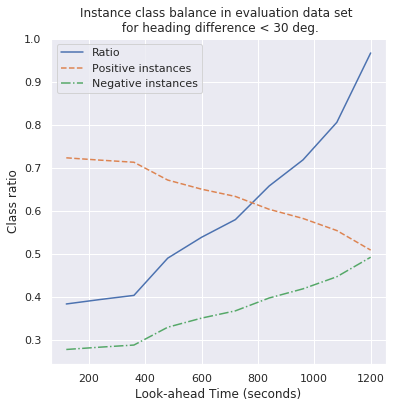

In [9]:
# f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(30,10))
plt.figure(figsize=(6,6))
bin_sec = 120
# for ty in type_list:
style_lst = iter(['-','--','-.'])
ttc_list = load_obj('../scripts/ttc_list_%s.pkl' % ty)

d = [t for t in ttc_list if t[0] > 60]
# d = [t for t in ttc_list if t[0] > 60 and abs(t[7]) > hdg_lim]
# d = [t for t in ttc_list if t[0] > 60 and abs(t[7]) < hdg_lim]
# d = [t for t in ttc_list if t[0] > 60 and t[3] > alt_lim and t[4] > alt_lim]
# d = [t for t in ttc_list if t[0] > 60 and t[3] < alt_lim and t[4] < alt_lim]

ttc_act = []
ttc_est = []
ttc_diff = []
lat = 120
ratios = []
la_times = []
pos = []
neg = []

count = []

for b in range(int(1200 / bin_sec)):
    bmin = b * bin_sec
    bmax = bmin + bin_sec

    len_neg = len([v for v in d if np.isnan(v[1]) if bmin < v[0] < bmax])
    len_pos = len([v for v in d if ~np.isnan(v[1]) if bmin < v[0] < bmax])
    count.append(len_neg + len_pos)
    pos.append(len_pos/(len_neg + len_pos))
    neg.append(len_neg/(len_neg + len_pos))

    ratios.append(len_neg/len_pos)
    la_times.append(bmax)

plt.plot(la_times, ratios, linestyle=next(style_lst), label='Ratio')
plt.plot(la_times, pos, linestyle=next(style_lst), label='Positive instances')
plt.plot(la_times, neg, linestyle=next(style_lst), label='Negative instances')
plt.xlabel('Look-ahead Time (seconds)')
plt.ylabel('Class ratio')
plt.title('Instance class balance in evaluation data set \n for heading difference < 30 deg.')
plt.legend()
    
plt.show()


In [ ]:
ttc_list

In [ ]:
ttcdf = pd.DataFrame(ttc_list)

ttcdf.columns = ['la_max','ttc_act_i','ttc_est_i','alt_1','alt_2','alt_c_1','alt_c_2','hdg_diff_i']

ttcdf['ttc_diff'] = ttcdf['ttc_act_i'] - ttcdf['ttc_est_i']
ttcdf['ttc_rat'] = ttcdf['ttc_act_i'] / ttcdf['ttc_est_i']

In [ ]:
ttcdf['ttc_rat'].hist(bins=100)

In [ ]:
ttcdf['ttc_rat'].describe()

In [ ]:
len(ttcdf[ttcdf['ttc_act_i'].isna() != True])

In [ ]:
for ty in type_list:
    
    ttc_list = load_obj('../scripts/ttc_list_%s.pkl' % ty)
    ttc_list = [t for t in ttc_list if t[0] > 60]
    perf_dicts[ty] = create_la_performance_dict(ttc_list, bin_sec=120)

In [ ]:
plt.figure(figsize=(30,30))
plt.scatter(ttcdf['ttc_est_i'], ttcdf['ttc_act_i'])
plt.xlim(0,400)
plt.ylim(0,400)

In [ ]:
plt.figure(figsize=(30,30))
plt.scatter(ttcdf['la_max'], ttcdf['ttc_diff'])
# plt.xlim(0,100)
# plt.ylim(0,2)

In [ ]:
len(ttcdf[ttcdf['ttc_diff'].isna() == False])

In [ ]:
len(ttcdf[ttcdf['ttc_act_i'].isna() == True])